<a href="https://colab.research.google.com/github/sanxku/sarcasm-detection/blob/main/165_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Import Requirements

In [ ]:
!pip install pandas numpy scikit-learn nltk spacy matplotlib vaderSentiment datasets
!python -m spacy download en_core_web_sm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 94.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import spacy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Load Data

In [ ]:
from datasets import load_dataset

dataset = load_dataset("nikesh66/Sarcasm-dataset")
df = pd.DataFrame(dataset['train'])

df = df.rename(columns={"Tweet": "content", "Sarcasm (yes/no)": "label"})

df["label"] = df["label"].map({"yes": 1, "no": 0})

df.head()



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/420 [00:00<?, ?B/s]

sarcasm_tweets.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/5000 [00:00<?, ? examples/s]

,content,label
0,I genuinely love musicians.,0
1,I find vegetarians to be wonderful.,0
2,Because artists really make everything better.,1
3,Can't wait for more of the game.,1
4,"Oh great, another artists. Just what I needed.",1


In [ ]:
# Step 2 — Clean Text
def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\S+", "", text)
    text = re.sub(r"[^A-Za-z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.lower().strip()

df["clean_text"] = df["content"].apply(clean_text)



# Clean and Preprocess Data

In [ ]:
# Step 3 — Sentiment features (VADER)
analyzer = SentimentIntensityAnalyzer()

df["sentiment"] = df["clean_text"].apply(lambda t: analyzer.polarity_scores(t)["compound"])



In [ ]:
# Step 4 — POS features using spaCy
nlp = spacy.load("en_core_web_sm")

docs = list(nlp.pipe(df["clean_text"], batch_size=1000, disable=["ner"]))

def pos_ratio(doc, pos):
    return len([t for t in doc if t.pos_ == pos]) / (len(doc) + 1e-5)

df["adv_ratio"] = [pos_ratio(d, "ADV") for d in docs]
df["adj_ratio"] = [pos_ratio(d, "ADJ") for d in docs]

# Simple intensifiers list
intensifiers = ["literally", "totally", "seriously", "really"]
df["intensifiers"] = df["clean_text"].apply(lambda t: sum(word in t.split() for word in intensifiers))



In [ ]:
# Step 5 — Punctuation / emphasis features
def punct_feats(text):
    return {
        "exclaim": text.count("!"),
        "caps": sum(1 for w in text.split() if w.isupper())
    }

df["exclaim"] = df["content"].apply(lambda x: punct_feats(str(x))["exclaim"])
df["caps"] = df["content"].apply(lambda x: punct_feats(str(x))["caps"])


# TF-IDF Vectorization

In [ ]:
# Step 6 — TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(df["clean_text"])



In [ ]:
# Step 7 — Combine numeric features with TF-IDF

numeric_features = df[["sentiment","adv_ratio","adj_ratio","intensifiers","exclaim","caps"]].values
X = hstack([X_tfidf, numeric_features])
y = df["label"].values


# Models

In [ ]:
# Step 8 — Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
# Logistic Regression evaluation
lr = LogisticRegression(max_iter=500)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
print("F1-score:", f1_score(y_test, y_pred_lr))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("\n")

# SVM evaluation
svc = SVC()
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

print("SVM (linear kernel):")
print("Accuracy:", accuracy_score(y_test, y_pred_svc))
print("Precision:", precision_score(y_test, y_pred_svc))
print("Recall:", recall_score(y_test, y_pred_svc))
print("F1-score:", f1_score(y_test, y_pred_svc))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_svc))
print("\n")

# --- Misclassified tweets for discussion ---
misclassified_idx = np.where(y_test != y_pred_lr)[0]
misclassified_tweets = df.iloc[misclassified_idx]

print("Example misclassified tweets (Logistic Regression):")
print(misclassified_tweets[["content", "label"]].head(5))


Logistic Regression:
Accuracy: 0.929
Precision: 0.973741794310722
Recall: 0.8829365079365079
F1-score: 0.9261186264308012
Confusion matrix:
 [[484  12]
 [ 59 445]]


SVM (linear kernel):
Accuracy: 0.929
Precision: 0.973741794310722
Recall: 0.8829365079365079
F1-score: 0.9261186264308012
Confusion matrix:
 [[484  12]
 [ 59 445]]


Example misclassified tweets (Logistic Regression):
                                             content  label
16   Oh great, another athletes. Just what I needed.      1
20               I just love when this book happens.      1
39   vegetarians are so wonderful, said no one ever.      1
61                   doctors have always been great.      0
73  the workshop are so wonderful, said no one ever.      1


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, random_state=42
)

# Vectorize using CountVectorizer (no negative values ever)
vectorizer = CountVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print("Naive Bayes:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb))
print("Recall:", recall_score(y_test, y_pred_nb))
print("F1-score:", f1_score(y_test, y_pred_nb))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_nb))


Naive Bayes:
Accuracy: 0.948
Precision: 1.0
Recall: 0.896
F1-score: 0.9451476793248945
Confusion matrix:
 [[500   0]
 [ 52 448]]


# Sentiment Analysis + Linguistic Features

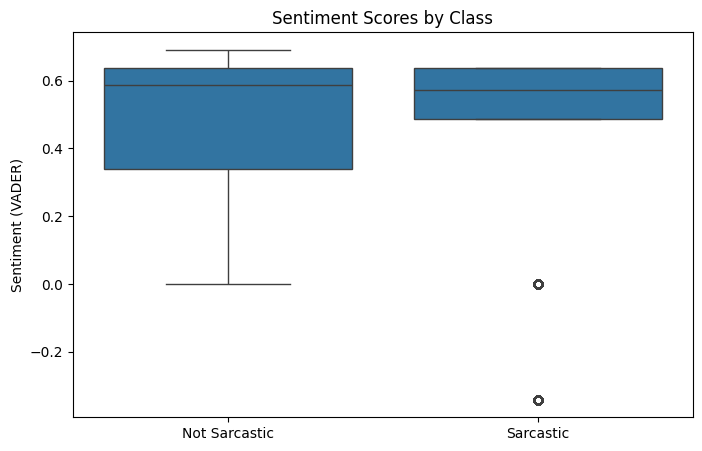

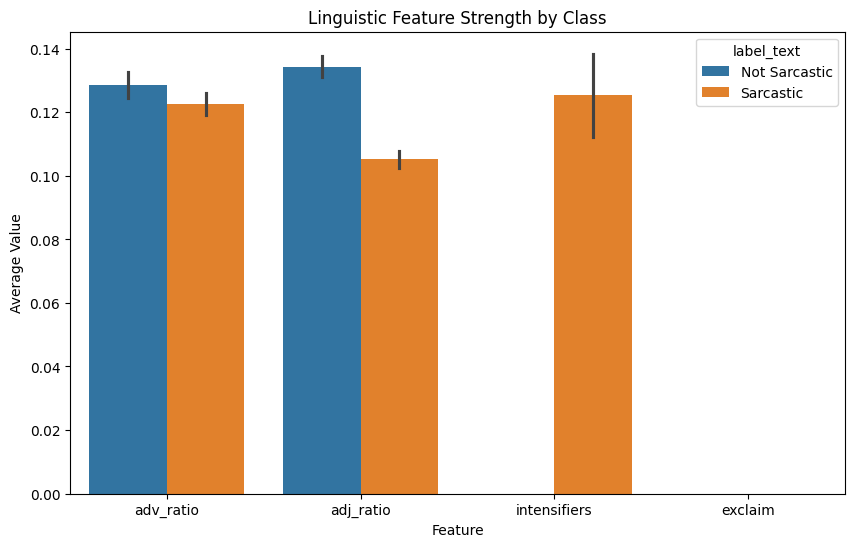

In [ ]:
# df["sentiment"], df["adv_ratio"], df["adj_ratio"], df["intensifiers"], df["exclaim"], df["label"]

df["label_text"] = df["label"].map({0: "Not Sarcastic", 1: "Sarcastic"})

# Sentiment Distribution Plot
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="label_text", y="sentiment")
plt.title("Sentiment Scores by Class")
plt.xlabel("")
plt.ylabel("Sentiment (VADER)")
plt.show()

# Linguistic Feature Comparison
feature_cols = ["adv_ratio", "adj_ratio", "intensifiers", "exclaim"]

df_melted = df[feature_cols + ["label_text"]].melt(id_vars="label_text")

plt.figure(figsize=(10,6))
sns.barplot(
    data=df_melted,
    x="variable",
    y="value",
    hue="label_text",
    errorbar=("ci", 95)
)
plt.title("Linguistic Feature Strength by Class")
plt.xlabel("Feature")
plt.ylabel("Average Value")
plt.show()


# Word Cloud - Sarcastic vs Non-Sarcastic

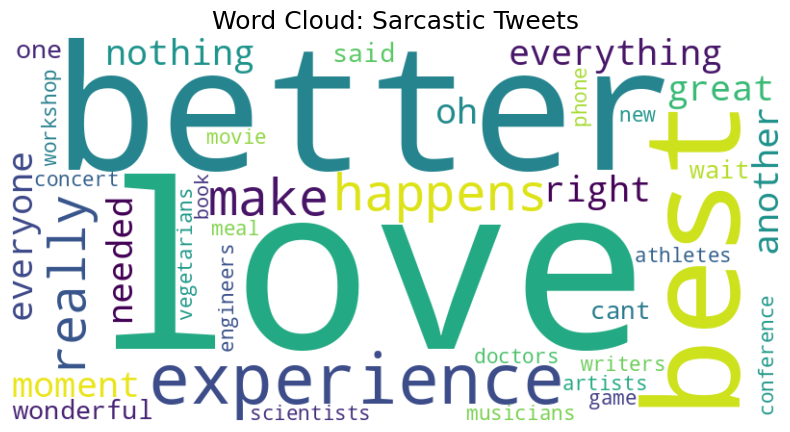

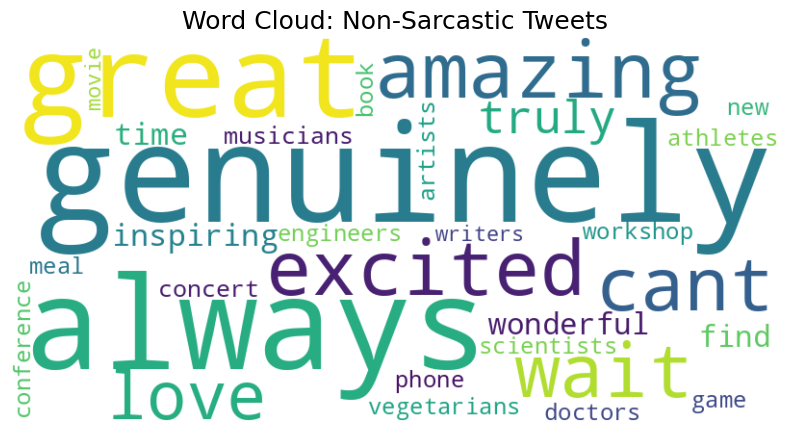

In [ ]:
!pip install wordcloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt

sarcastic_text = " ".join(df[df["label"] == 1]["clean_text"].tolist())
nonsarcastic_text = " ".join(df[df["label"] == 0]["clean_text"].tolist())

def show_wordcloud(text, title):
    wc = WordCloud(
        width=800,
        height=400,
        background_color="white",
        collocations=False
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=18)
    plt.show()

# Sarcastic word cloud
show_wordcloud(sarcastic_text, "Word Cloud: Sarcastic Tweets")

# Non-sarcastic word cloud
show_wordcloud(nonsarcastic_text, "Word Cloud: Non-Sarcastic Tweets")
